In [15]:
from matplotlib import pyplot as plt

In [42]:
import tqdm
import numpy as np
import os
import numpy as np
from PIL import Image
from pytorch_utils.pytorch_utils import ToOpponentChannel, ToRGBEdges
from oads_access.oads_access import OADS_Access, get_annotation_dimensions
from oads_access.utils import loadmat
from pytorch_utils.pytorch_utils import ToRGBEdges
from lgnpy.CEandSC.lgn_statistics import get_edge_maps

In [5]:
oads = OADS_Access(basedir='/home/nmuller/projects/data/oads/', n_processes=8)
    
crop_dir = '/home/nmuller/projects/data/oads/oads_arw/crops/ML_edges'


threshold_lgn_path = f'{os.path.expanduser("~")}/projects/lgnpy/ThresholdLGN.mat'
default_config_path = f'{os.path.expanduser("~")}/projects/lgnpy/lgnpy/CEandSC/default_config.yml'
threshold_lgn = loadmat(threshold_lgn_path)['ThresholdLGN']


image_ids = []
for image_name, info in oads.image_names.items():
    image_ids.append(image_name)
    # # if len(dataset_names) > 0 and info['dataset_name'] not in dataset_names:
    # #     continue
    # for index, _ in oads.image_names[image_name]['object_labels'].items():
    #         image_ids.append((image_name, index))

image_ids = list(set(image_ids))

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [12]:
ToEdges = ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path)

In [8]:
image_name = image_ids[0]
index = 0

In [11]:
tup = oads.load_image(image_name=image_name)

if tup is None:
    print(f'tup is none: {image_name}')
img, label = tup

In [13]:
img = ToEdges(img)

In [77]:
def load_edge_map_crops_for_image(image_name, ToEdges):
    tup = oads.load_image(image_name=image_name)

    if tup is None:
        print(f'tup is none: {image_name}')
        return None
    
    img, label = tup

    img = ToEdges(img)

    is_raw = label['is_raw']
    # if self.use_jpeg:
    #     img = ToJpeg(resize=False, p=self.jpeg_p, quality=self.jpeg_quality)(img)
    #     # is_raw = False

    # This index needs to be normalized/adjust somehow
    crops = {}
    for index in range(len(label['objects'])):
        obj = label['objects'][index]

        ((left, top), (right, bottom)) = get_annotation_dimensions(obj, is_raw=is_raw)
        crop = []
        for _x in img.transpose((2,0,1)):
            crop.append(np.array(Image.fromarray(_x).crop(((left, top, right, bottom)))))

        parvo = np.dstack((crop[0], crop[1], crop[2]))
        magno = np.dstack((crop[3], crop[4], crop[5]))

        crops[index] = {'parvo': parvo, 'magno': magno, 'image_name': image_name, 'class': obj['classTitle']}

    return crops

In [78]:
crops = load_edge_map_crops_for_image(image_name=image_ids[1], ToEdges=ToEdges)

In [90]:
parvo = crops[3]['parvo']
magno = crops[3]['magno']
classtitle = crops[3]['class']

In [98]:
parvo.shape

(640, 1112, 3)

In [143]:
from skimage.measure import block_reduce
from torchvision import transforms
import torch

In [158]:
class EdgeResize(object):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.resize = transforms.Compose([transforms.Resize(self.size)])

    def __call__(self, sample):
        arr = []
        for _x in sample.transpose((2,0,1)):
            res = np.array(self.resize(Image.fromarray(_x)))
            arr.append(res)

        return torch.tensor(np.dstack(arr))

In [159]:
EdgeResize((400, 400))(parvo).shape

(640, 1112, 3)
(400, 400)
(400, 400)
(400, 400)


torch.Size([400, 400, 3])

In [134]:
tfms = transforms.Compose([transforms.Resize((400, 400)),
                           transforms.ToTensor()])

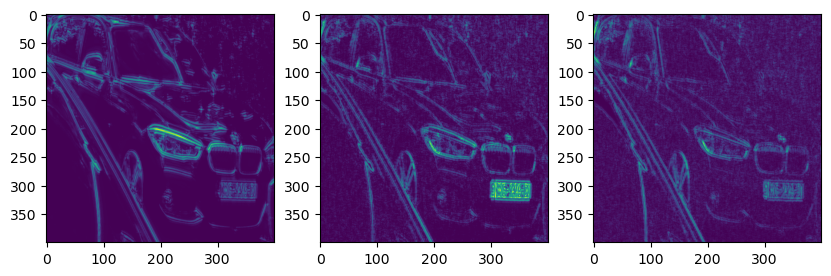

In [140]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

for index, _x in enumerate(parvo.transpose((2,0,1))):
    ax[index].imshow(tfms(Image.fromarray(_x))[0,:,:])

plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

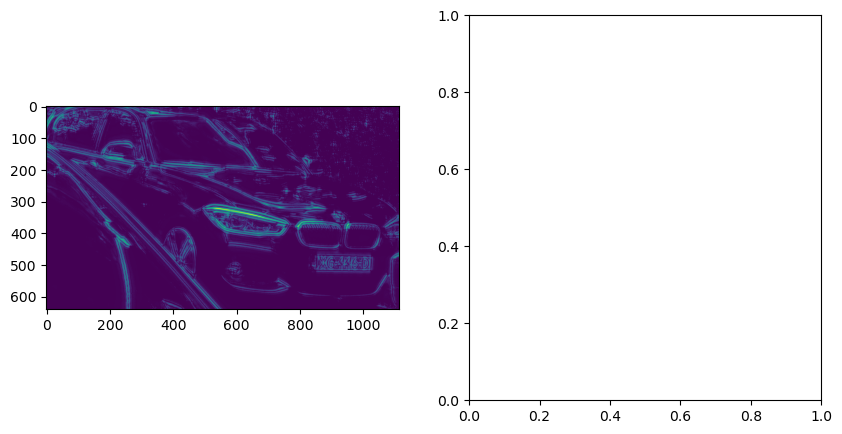

In [113]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(parvo[:,:,0])
ax[1].imshow(block_reduce(parvo, block_size=(2 ,5, 1))[:,:,0])

plt.show()

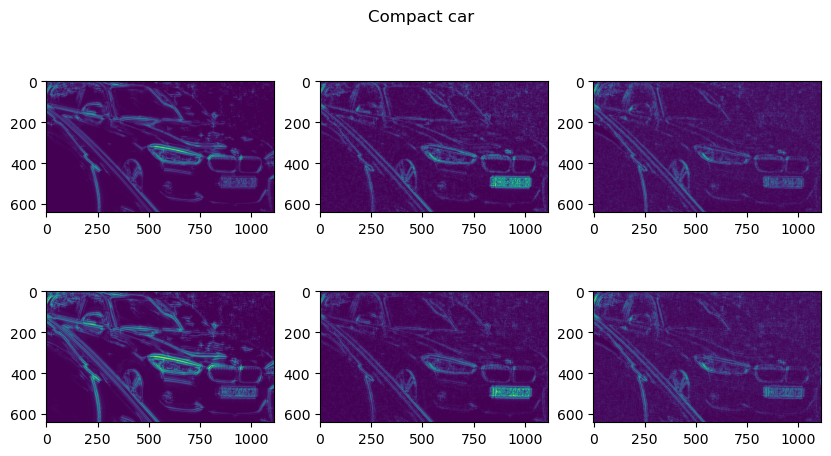

In [91]:
fig, ax = plt.subplots(2,3, figsize=(10,5))
ax[0, 0].imshow(parvo[:,:,0])
ax[1, 0].imshow(magno[:,:,0])
ax[0, 1].imshow(parvo[:,:,1])
ax[1, 1].imshow(magno[:,:,1])
ax[0, 2].imshow(parvo[:,:,2])
ax[1, 2].imshow(magno[:,:,2])

fig.suptitle(classtitle)

plt.show()

In [96]:
parvo.size / 1024 / 1024

2.0361328125

In [97]:
np.save('/home/nmuller/projects/test_parvo.npy', arr=parvo, allow_pickle=False)

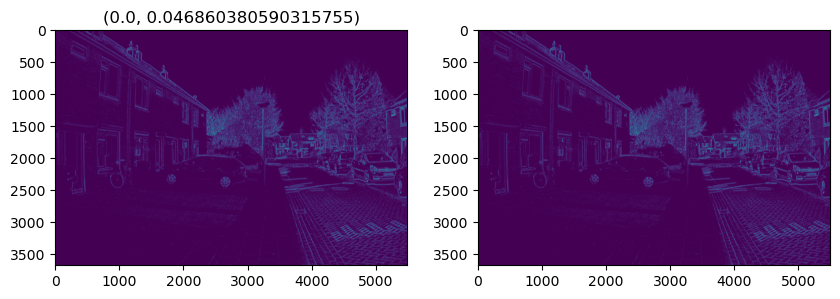

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img[:,:,0])
ax[0].set_title((img[:,:,0].min(), img[:,:,0].max()))
ax[1].imshow(np.abs(img[:,:,0]))
plt.show()

In [59]:
((left, top), (right, bottom)) = get_annotation_dimensions(obj, is_raw=True)
crops = []
for _x in img.transpose((2,0,1)):
    crops.append(np.array(Image.fromarray(_x).crop(((left, top, right, bottom)))))
# Image.fromarray(img.transpose((2,0,1))[0])

In [60]:
crops[0]

array([[0.00197599, 0.00143611, 0.00101577, ..., 0.00055205, 0.00060344,
        0.00061356],
       [0.00201658, 0.00145709, 0.00101266, ..., 0.00109058, 0.00085429,
        0.00055603],
       [0.00208609, 0.00155801, 0.00114041, ..., 0.00111948, 0.00118014,
        0.00115275],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00472007, 0.00373865,
        0.0030495 ],
       [0.        , 0.        , 0.        , ..., 0.00030992, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00151481, 0.00266813,
        0.00364718]], dtype=float32)

In [19]:

is_raw = label['is_raw']
# if self.use_jpeg:
#     img = ToJpeg(resize=False, p=self.jpeg_p, quality=self.jpeg_quality)(img)
#     # is_raw = False

# This index needs to be normalized/adjust somehow
obj = label['objects'][index]
# if self.exclude_oversized_crops:
#     width, height = self.get_annotation_size(
#         obj, is_raw=is_raw)
#     if height > self.max_size_crops[0] or width > self.max_size_crops[1]:
#         return None
crop = oads.get_image_crop(
    img=img, object=obj, is_raw=is_raw)

TypeError: Cannot handle this data type: (1, 1, 6), <f8

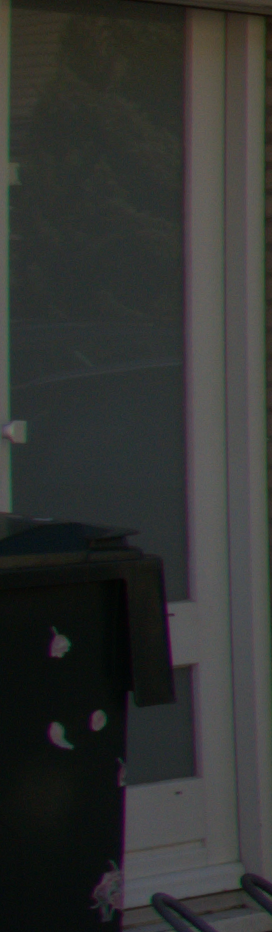

In [10]:
crop